In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pygsp as pygsp
import matplotlib.cm as cm

from tqdm import tqdm
import numpy as np
import random


In [9]:
# Trace builiding code
class Trace:
    def __init__(self):
        self.calls = []

class Node_info:
    def __init__(self, num_id, n_type):
        self.num_id = num_id
        self.n_type = n_type

class Call:
    def __init__(self, traceid, timestamp, rpcid, um, dm, rpctype, interface, rt):
        self.traceid = traceid
        self.timestamp = timestamp
        self.rpcid = rpcid
        self.um = um
        self.dm = dm 
        self.rpctype = rpctype
        self.interface = interface
        self.rt = rt
    def string(self):
        return self.traceid + "," + str(self.timestamp) + "," + self.rpcid + "," + self.um + "," + self.dm + "," +\
            self.rpctype + "," + self.interface + "," + str(self.rt)

def csv_to_df(file: str):
    df = pd.read_csv(file)
    return df

def extract_traceid_rows(df, tid):
    f_df = df[df['traceid'] == tid]
    tid_calls = [
        Call(
            str(row.traceid), 
            int(row.timestamp), 
            str(row.rpcid), 
            str(row.um), 
            str(row.dm), 
            str(row.rpctype), 
            str(row.interface), 
            int(row.rt)
        ) for row in f_df.itertuples(index=False)
    ]
    return tid_calls
def plot_agg_graphnx(G, colors, pos=None, edge_width=0.8, node_size=20, alpha=0.55, title=""):
    """
    pos : dict, optional
        A dictionary with nodes as keys and positions as values.
        If not provided, will use spring layout.

    """
    if pos is None:
        pos = nx.spring_layout(G)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1, projection='3d' if len(next(iter(pos.values()))) == 3 else None)
    ax.axis("off")
    ax.set_title(title)

    # Draw edges and nodes
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=alpha, width=edge_width)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size, alpha=alpha, node_color=colors)

    fig.tight_layout()
    plt.savefig("test.png", format='png')
    plt.close(fig)

    return fig

import matplotlib.pyplot as plt
import networkx as nx

def plot_colored_graphnx(G, sf_list, sl_list, pos=None, edge_width=0.8, node_size=20, alpha=0.55, title=""):

    if pos is None:
        pos = nx.spring_layout(G)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1, projection='3d' if len(next(iter(pos.values()))) == 3 else None)
    ax.axis("off")
    ax.set_title(title)
    # color_map = []
    # for node in G:
    #     if node < 10:
    #         color_map.append('blue')
    #     else: 
    #         color_map.append('green') 
    # Draw edges and nodes
    options = {"node_size": node_size, "alpha": alpha}
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=alpha, width=edge_width)
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=sf_list, node_color="tab:green", **options) # statefull == green
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=sl_list, node_color="tab:blue", **options) # stateless == blue

    fig.tight_layout()
    plt.savefig("test.png", format='png')
    plt.close(fig)

    return fig



In [10]:
def get_dg_initial_node(G):
    initial_nodes = []
    for node, in_deg in G.in_degree():
        if in_deg == 0:
            initial_nodes.append(node)
    print("Initial nodes: ", initial_nodes)
    return initial_nodes

def get_dg_unique_nodes(G):
    res = set(G.nodes)
    print("Num of nodes: ", len(res))
    return res

'''
Generates node to type mapping
k: is the number of categories to increase for statefull nodes
'''
def node_type_map_gen(G, all_sf_nodes, all_sl_nodes, k = 0):
    node_type_map = {}
    for sf_node in all_sf_nodes:
        #randomly assigning the statefull node to a category
        cat = "db" + str(random.randint(0, k))
        node_type_map[sf_node] = cat
    for sl_node in all_sl_nodes:
        node_type_map[sl_node] = "mc"
    
    for node in G.nodes():
        if node not in node_type_map:
            node_type_map[node] = "mc"
            
    return node_type_map
    

In [11]:
# types :  ['userDefined', 'db', 'http', 'mq', 'rpc', 'mc']
# Extract to dataframe
df = csv_to_df("./MSCallGraph_0.csv")

# Extract all tids
tids_list = df['traceid'].unique()
print("Num of tids: ", len(tids_list))

Num of tids:  130512


  0%|          | 199/130512 [00:49<8:57:03,  4.04it/s]


Num of nodes:  266
Num of sf nodes:  27
Num of sl nodes:  233


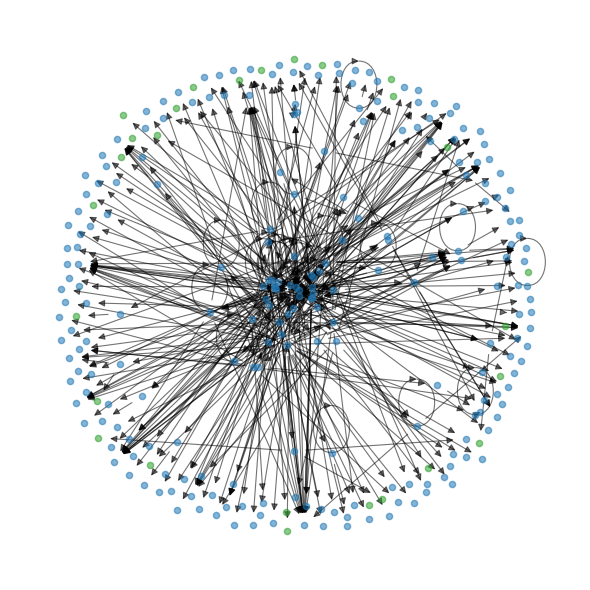

In [22]:
"""
Graph Building
"""

ctr = 0
all_edges = []
all_sl_nodes = []
all_sf_nodes = []
all_nodes = []
rpc_types = []
for i in tqdm(range(len(tids_list))):
    # if i in [0,1,2]:
    #     continue
    ctr += 1
    tid_calls = extract_traceid_rows(df, tids_list[i])
    for call in tid_calls:
        all_edges.append([call.um, call.dm])
        all_nodes.append(call.um)
        all_nodes.append(call.dm)
        # print(call.rpctype)
        # rpc_types.append(call.rpctype)
        if call.rpctype == "db":
            all_sf_nodes.append(call.dm)
        else: 
            all_sl_nodes.append(call.dm)
    # print("len tid:", len(tid_calls))
    if ctr == 200:
        break
all_nodes = list(set(all_nodes))
print("Num of nodes: ", len(all_nodes))
all_sf_nodes = list(set(all_sf_nodes))
print("Num of sf nodes: ", len(all_sf_nodes))
all_sl_nodes = list(set(all_sl_nodes))
print("Num of sl nodes: ", len(all_sl_nodes))

# unique_rpcs = list(set(rpc_types))
# print("types : ", unique_rpcs)

G = nx.DiGraph()
G.add_edges_from(all_edges)
plot_colored_graphnx(G, all_sf_nodes, all_sl_nodes)


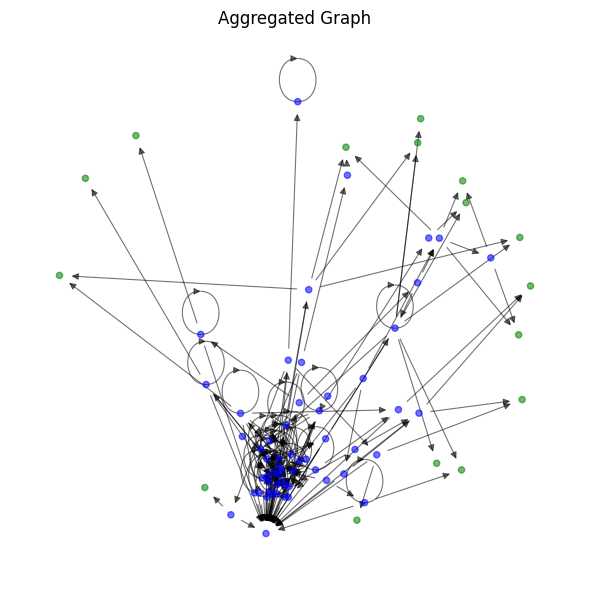

In [24]:
"""
SNAP Aggregation
"""

# node_type_map = {}
# for sf_node in all_sf_nodes:
#     node_type_map[sf_node] = "db"
# for sl_node in all_sl_nodes:
#     node_type_map[sl_node] = "mc"
# check = 0
# for node in G.nodes():
#     if node not in node_type_map:
#         check +=1
#         node_type_map[node] = "mc"
# print(check)
node_type_map = node_type_map_gen(G, all_sf_nodes, all_sl_nodes, 27)
# Define the node attributes to aggregate on
nx.set_node_attributes(G, node_type_map, 'type')
node_attributes = ("type",)

# Perform the snap aggregation
Gs = nx.snap_aggregation(G, node_attributes=node_attributes)

# Extract node types and assign colors
# color_map = {
#     "db": "green",
#     "mc": "blue",
#     "unknown": "gray"
# }
# colors = [color_map.get(Gs.nodes[node]['type'], "gray") for node in Gs.nodes()]
colors = []
for node in Gs.nodes():
    n_type = Gs.nodes[node]['type'] 
    if n_type[:2] == "db":
        colors.append("green")
    else:
        colors.append("blue")


# Plot the aggregated graph
plot_agg_graphnx(Gs, colors, title="Aggregated Graph")